# NY Fed Financial Conditions

## Packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import statsmodels.api as sm
import pandas_datareader as web

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from collect import *

## OOP Instance

In [2]:
ny_fed_collect = NYFedCollect()
#ny_fed_collect.collect()

## Read Data

In [3]:
df = pd.read_parquet(
    path = "financial_conditions_prep.parquet",
    engine = "pyarrow")

## EDA Plotting

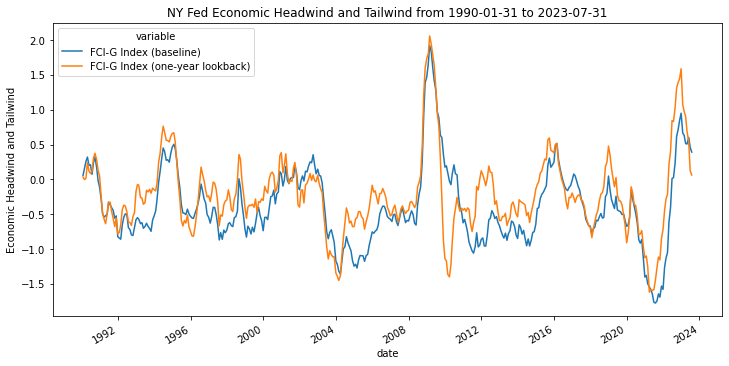

In [4]:
(df.set_index(
    "date").
    rename(columns = ny_fed_collect.inv_column_renamer).
    plot(
        figsize = (12, 6),
        ylabel = "Economic Headwind and Tailwind",
        title = "NY Fed Economic Headwind and Tailwind from {} to {}".format(
            df.date.min().date(), df.date.max().date())))

plt.show()

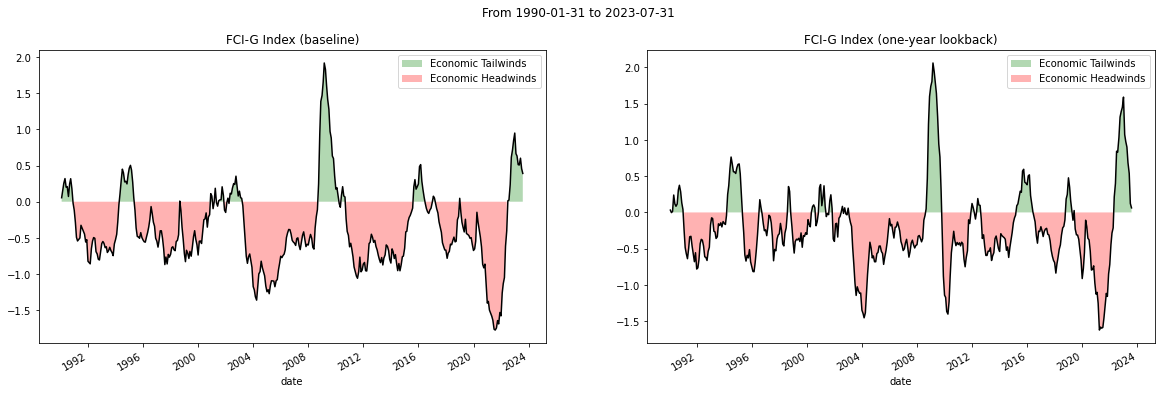

In [5]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))

df_plot_tmp = (df.assign(
    date = lambda x: pd.to_datetime(x.date)).
    set_index("date").
    sort_index().
    rename(columns = ny_fed_collect.inv_column_renamer))

for i, col in enumerate(df_plot_tmp.columns):
    
    (df_plot_tmp[
        col].
        plot(
            ax = axes[i],
            color = "black",
            title = col))
    
    axes[i].fill_between(
        x = df_plot_tmp.index.values,
        y1 = df_plot_tmp[col].values,
        y2 = 0,
        where = df_plot_tmp[col].values > 0,
        facecolor = "green",
        alpha = 0.3)
    
    axes[i].fill_between(
        x = df_plot_tmp.index.values,
        y1 = df_plot_tmp[col].values,
        y2 = 0,
        where = df_plot_tmp[col].values < 0,
        facecolor = "red",
        alpha = 0.3)
    
legend_elements = [
    Patch(facecolor = "green", alpha = 0.3, label = "Economic Tailwinds"),
    Patch(facecolor = "red", alpha = 0.3, label = "Economic Headwinds")]

axes[0].legend(handles = legend_elements)
axes[1].legend(handles = legend_elements)

fig.suptitle("From {} to {}".format(
    df.date.min().date(),
    df.date.max().date()))

plt.show()

## Examining in comparison to various asset classes

In this case we'll use a series of asset classes as well breakdowns within that asset class in comparison to this model
1. Equities: S&P 500, Russell 1000, Rusell 2000, Russell 3000, NASDAQ, Value Equities (VTV), Growth Equities (VUG)
2. Fixed Income: Treasuires (TLT), Investment Grade (AGG), High Yield (HYG)
3. Commodities: Gold (GLD), OIL (USO)
4. FX: US dollar index (DXY), 3m Treasury Bill (DGS3MO), 10y TIPS (DFII10)

We will also set up these regressions as Financial Conditions vs. 1m lag of the security to see if it can forecast. I will use the results to make future determinations and at this junction it should be noted that I am artificially overfitting the model by running the regression and then fitting the data on the same model. I've made this deliberate choice because I'd like to analyze all of the information and the data comes in monthly from 1992. I am also interested in the performance of the models during periods of stress such as 2008 and 2020. To avoid as much overfitting as I've artificially injected I'll keep my model as robust and less-complex as possible.

Get statistics ready for data collection

In [6]:
try:
    
    df_yf = pd.read_parquet(
        path = "yf_asset_data.parquet",
        engine = "pyarrow")
    
    df_fred = pd.read_parquet(
        path = "fred_tsy.parquet",
        engine = "pyarrow")
    
except:

    start_date, end_date = df.date.min().date(), df.date.max().date()
    equity_tickers = ["SPY", "IWB", "IWM", "IWV", "QQQ", "VTV", "VUG"]
    fixed_income_tickers = ["TLT", "AGG", "HYG"]
    commodities_tickers = ["GLD", "USO"]
    fx_tickers = ["DXY"]
    fred_tickers = ["DGS3MO", "DFII10"]

    yf_combined_tickers = equity_tickers + fixed_income_tickers + commodities_tickers + fx_tickers

    df_yf = (yf.download(
        tickers = yf_combined_tickers,
        start = start_date,
        end = end_date).
        reset_index().
        melt(id_vars = "Date"))

    df_yf.to_parquet(
        path = "yf_asset_data.parquet",
        engine = "pyarrow")

    df_fred = (web.DataReader(
        name = fred_tickers,
        data_source = "fred",
        start = start_date,
        end = end_date))

    df_fred.to_parquet(
        path = "fred_tsy.parquet",
        engine = "pyarrow")

Clean and combine data

In [7]:
df_yf_prep = (df_yf.query(
    "variable_0 == 'Adj Close'").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    dropna())

df_fred_prep = (df_fred.reset_index().rename(
    columns = {"DATE": "Date"}).
    melt(id_vars = "Date").
    dropna().
    rename(columns = {"variable": "ticker"}))

df_combined = pd.concat([df_yf_prep, df_fred_prep])

Get the data into monthly format

In [8]:
def _monthly_resample(df: pd.DataFrame) -> pd.DataFrame:
    return(df.set_index("Date").resample("M").last())

df_combined_monthly = (df_combined.groupby(
    "ticker").
    apply(_monthly_resample).
    drop(columns = ["ticker"]).
    reset_index().
    rename(columns = {"Date": "date"}))

Now take percent change and shift and then remerge

In [9]:
df_monthly_rtn = (df_combined_monthly.pivot(
    index = "date", columns = "ticker", values = "value").
    pct_change().
    shift(1).
    reset_index().
    melt(id_vars = "date").
    dropna())

In [10]:
df_fi_combined = (df.melt(
    id_vars = "date").
    rename(columns = {
        "variable": "fi_index",
        "value": "fi_value"}).
    merge(df_monthly_rtn, how = "inner", on = ["date"]).
    rename(columns = {"value": "rtn"}))

C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
C:\Users\Diego\AppData\Local\Temp/ipykernel_22452/3149855463.py:27: RuntimeWarning: invalid value encountered in add
  y = (beta * x) + alpha
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1697: RuntimeWarning: invalid value encountered in subtract
  return self.model.wendog - self.model.predict(
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1732: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
C:\Users\Diego\AppData\Local\Temp/ipykernel_22452/3149855463.py:27: RuntimeWarning: invalid value encountered in add
  y = (beta * x) + alpha
C:\Users\Diego\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1697: RuntimeWarning: invalid value encountered in subtra

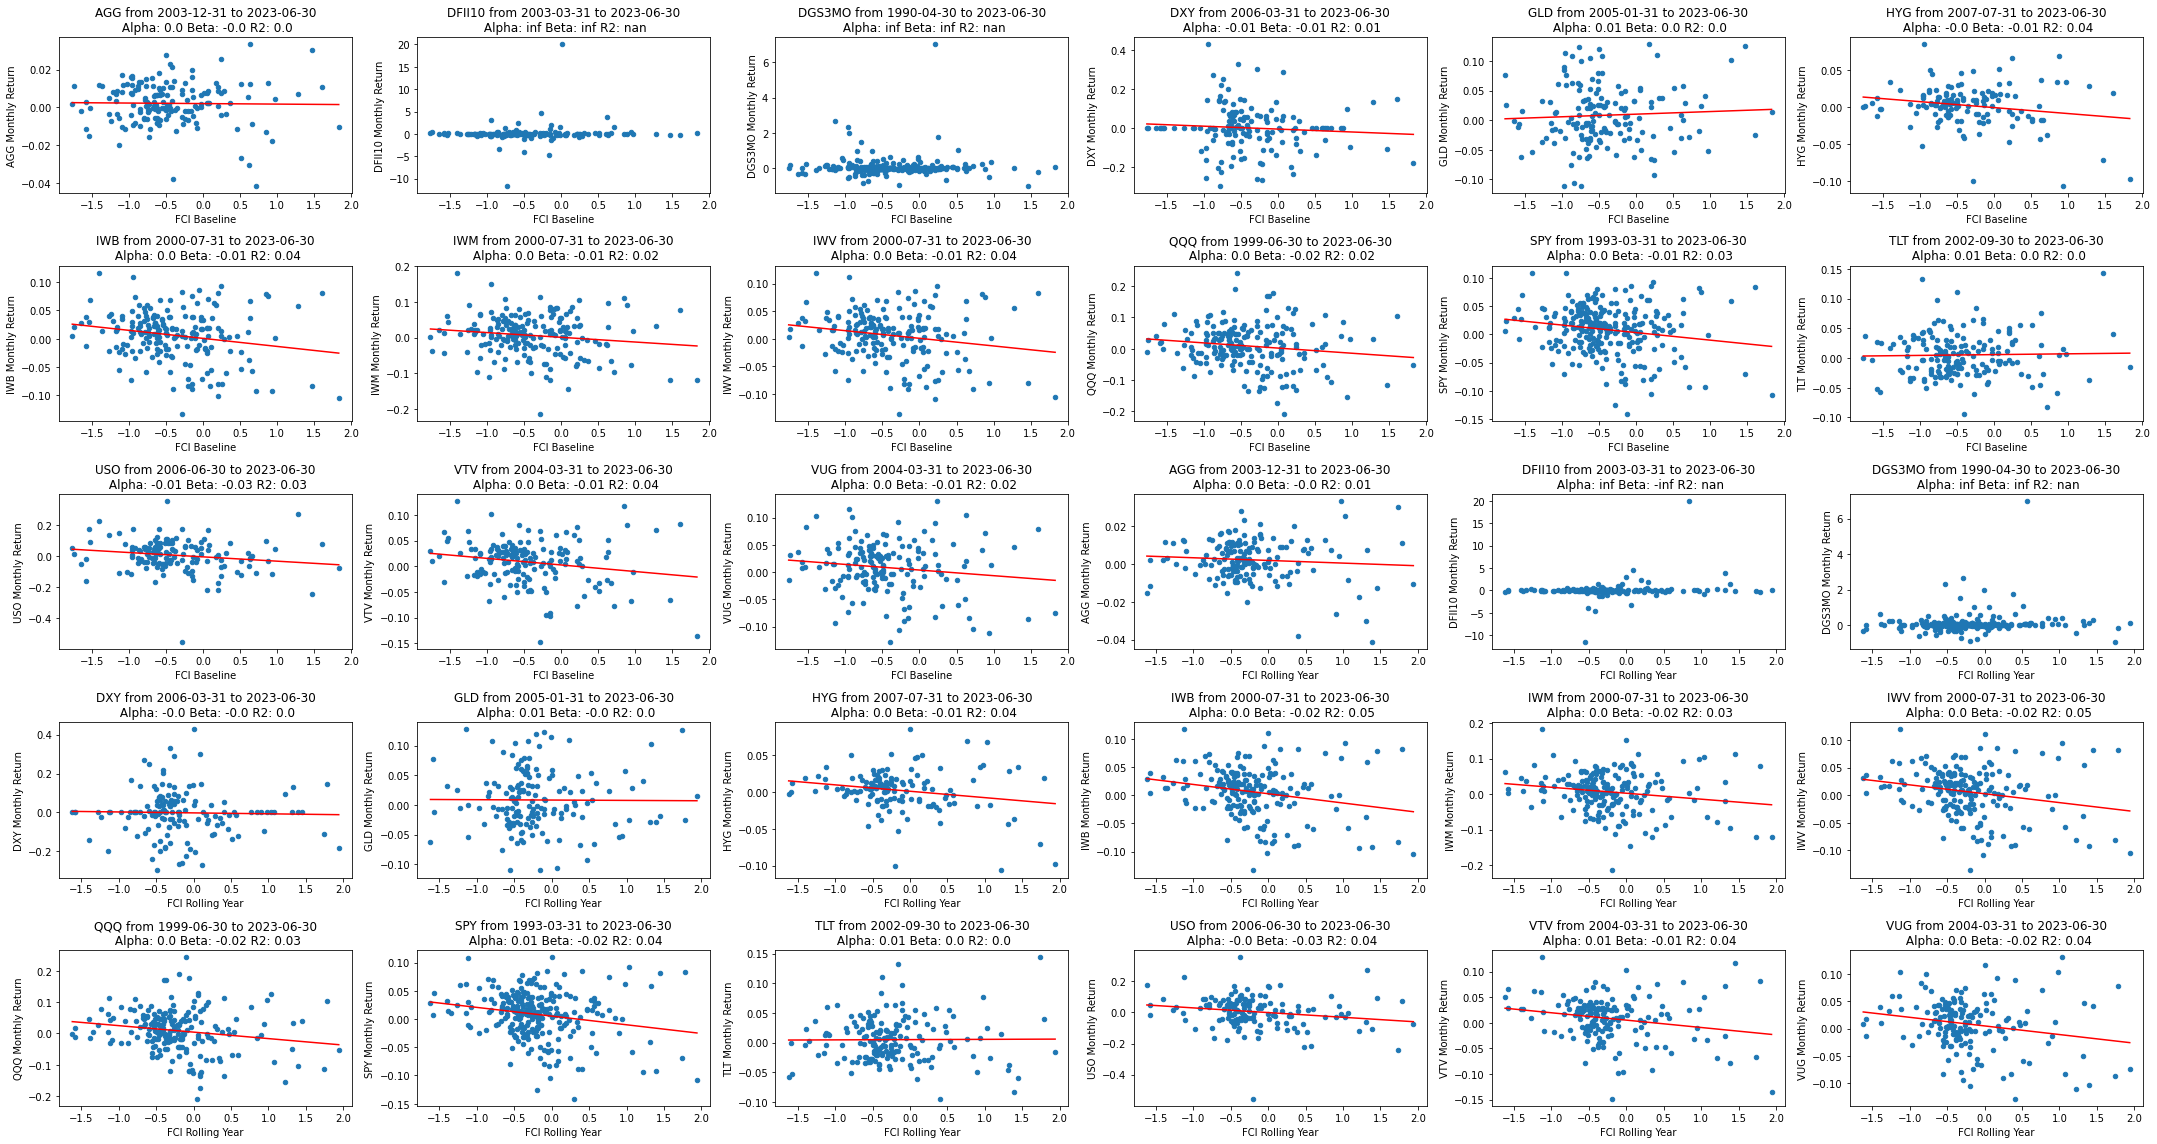

In [11]:
df_fi_combined_grouped = df_fi_combined.groupby(["fi_index", "ticker"])
df_param = pd.DataFrame(columns = ["alpha", "beta", "rsquared", "ticker"])

fig, axes = plt.subplots(ncols = 6, nrows = 5, figsize = (30, 16))

i, j = 0, 0
for group in df_fi_combined_grouped:
    
    if group[1].fi_index.iloc[0] == "fci_baseline":
        col_name = "FCI Baseline"
        
    else: col_name = "FCI Rolling Year"
    
    regression = (sm.OLS(
        endog = group[1].rtn,
        exog = sm.add_constant(group[1].fi_value)).
        fit())
    
    alpha, beta = regression.params
    rsquared = regression.rsquared
    
    x = np.linspace(
        start = group[1].fi_value.min(),
        stop = group[1].fi_value.max(),
        num = 1_000)
    
    y = (beta * x) + alpha
    
    (group[
        1].
        plot(
            kind = "scatter",
            x = "fi_value", y = "rtn",
            ax = axes[i,j],
            xlabel = col_name,
            ylabel = "{} Monthly Return".format(
                group[1].ticker.iloc[0]),
            title = "{} from {} to {}\n Alpha: {} Beta: {} R2: {}".format(
                group[1].ticker.iloc[0],
                group[1].date.min().date(),
                group[1].date.max().date(),
                round(alpha, 2),
                round(beta, 2),
                round(rsquared, 2))))
    
    axes[i,j].plot(x, y, color = "red")
    
    if j == 5:
        i += 1
        j = 0
        
    else: 
        j += 1
        
    df_param_tmp = pd.DataFrame({
        "alpha": [alpha],
        "beta": [beta],
        "rsquared": [rsquared],
        "ticker": [group[1].ticker.iloc[0]]})
    
    df_param = pd.concat([df_param, df_param_tmp])

    
plt.tight_layout()

Let's analyze the distribution of the parameters

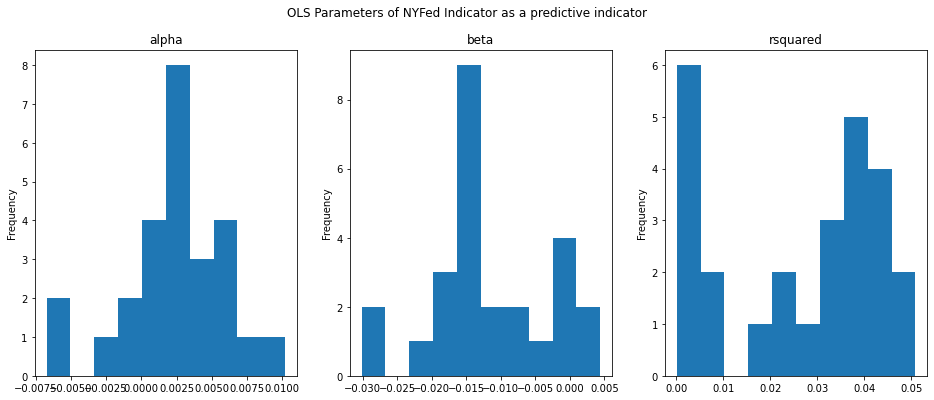

In [12]:
df_param_cleaned = (df_param.melt(
    id_vars = "ticker").
    query("value != inf & value != -inf").
    dropna())

fig, axes = plt.subplots(ncols = 3, figsize = (16, 6))
for i, variable in enumerate(df_param_cleaned.variable.drop_duplicates().to_list()):
    
    (df_param_cleaned.query(
        "variable == @variable")
        [["value"]].
        plot(
            kind = "hist",
            title = variable,
            ax = axes[i],
            legend = False))
    
fig.suptitle("OLS Parameters of NYFed Indicator as a predictive indicator")
plt.show()

Need to add a dataframe that appends the results from the regression and then analyze it from there

## Using it as regime change

In [13]:
df_signal = (df.melt(
    id_vars = "date").
    assign(sign = lambda x: np.sign(x.value)).
    drop(columns = ["value"]))

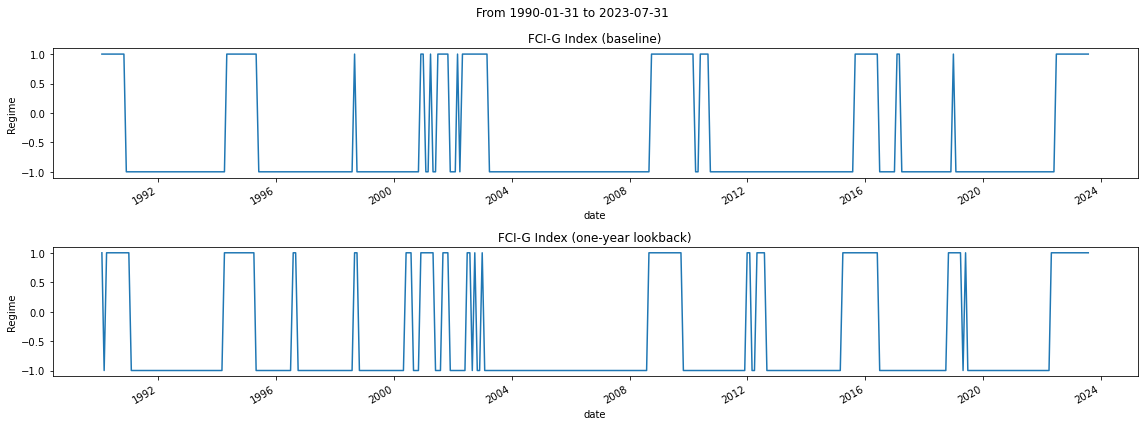

In [14]:
fig, axes = plt.subplots(nrows = 2, figsize = (16, 6))

df_plot = (df_signal.pivot(
    index = "date", columns = "variable", values = "sign").
    rename(columns = ny_fed_collect.inv_column_renamer))

for i, col in enumerate(df_plot.columns):
    
    (df_plot[
        col].
        plot(
            ax = axes[i],
            ylabel = "Regime",
            title = col))
    
fig.suptitle("From {} to {}".format(
    df_plot.index.min().date(),
    df_plot.index.max().date()))
plt.tight_layout()
plt.show()

# Using it to segregate regimes

In this example we'll use the FCI Rolling 1y 

In [69]:
df_signal_combined = (df_monthly_rtn.merge(
    right = df_signal,
    how = "inner",
    on = ["date"]).
    query("variable == 'fci_rolling_year'").
    drop(columns = ["variable"]))

In [126]:
len(df_signal_combined.ticker.drop_duplicates())

15

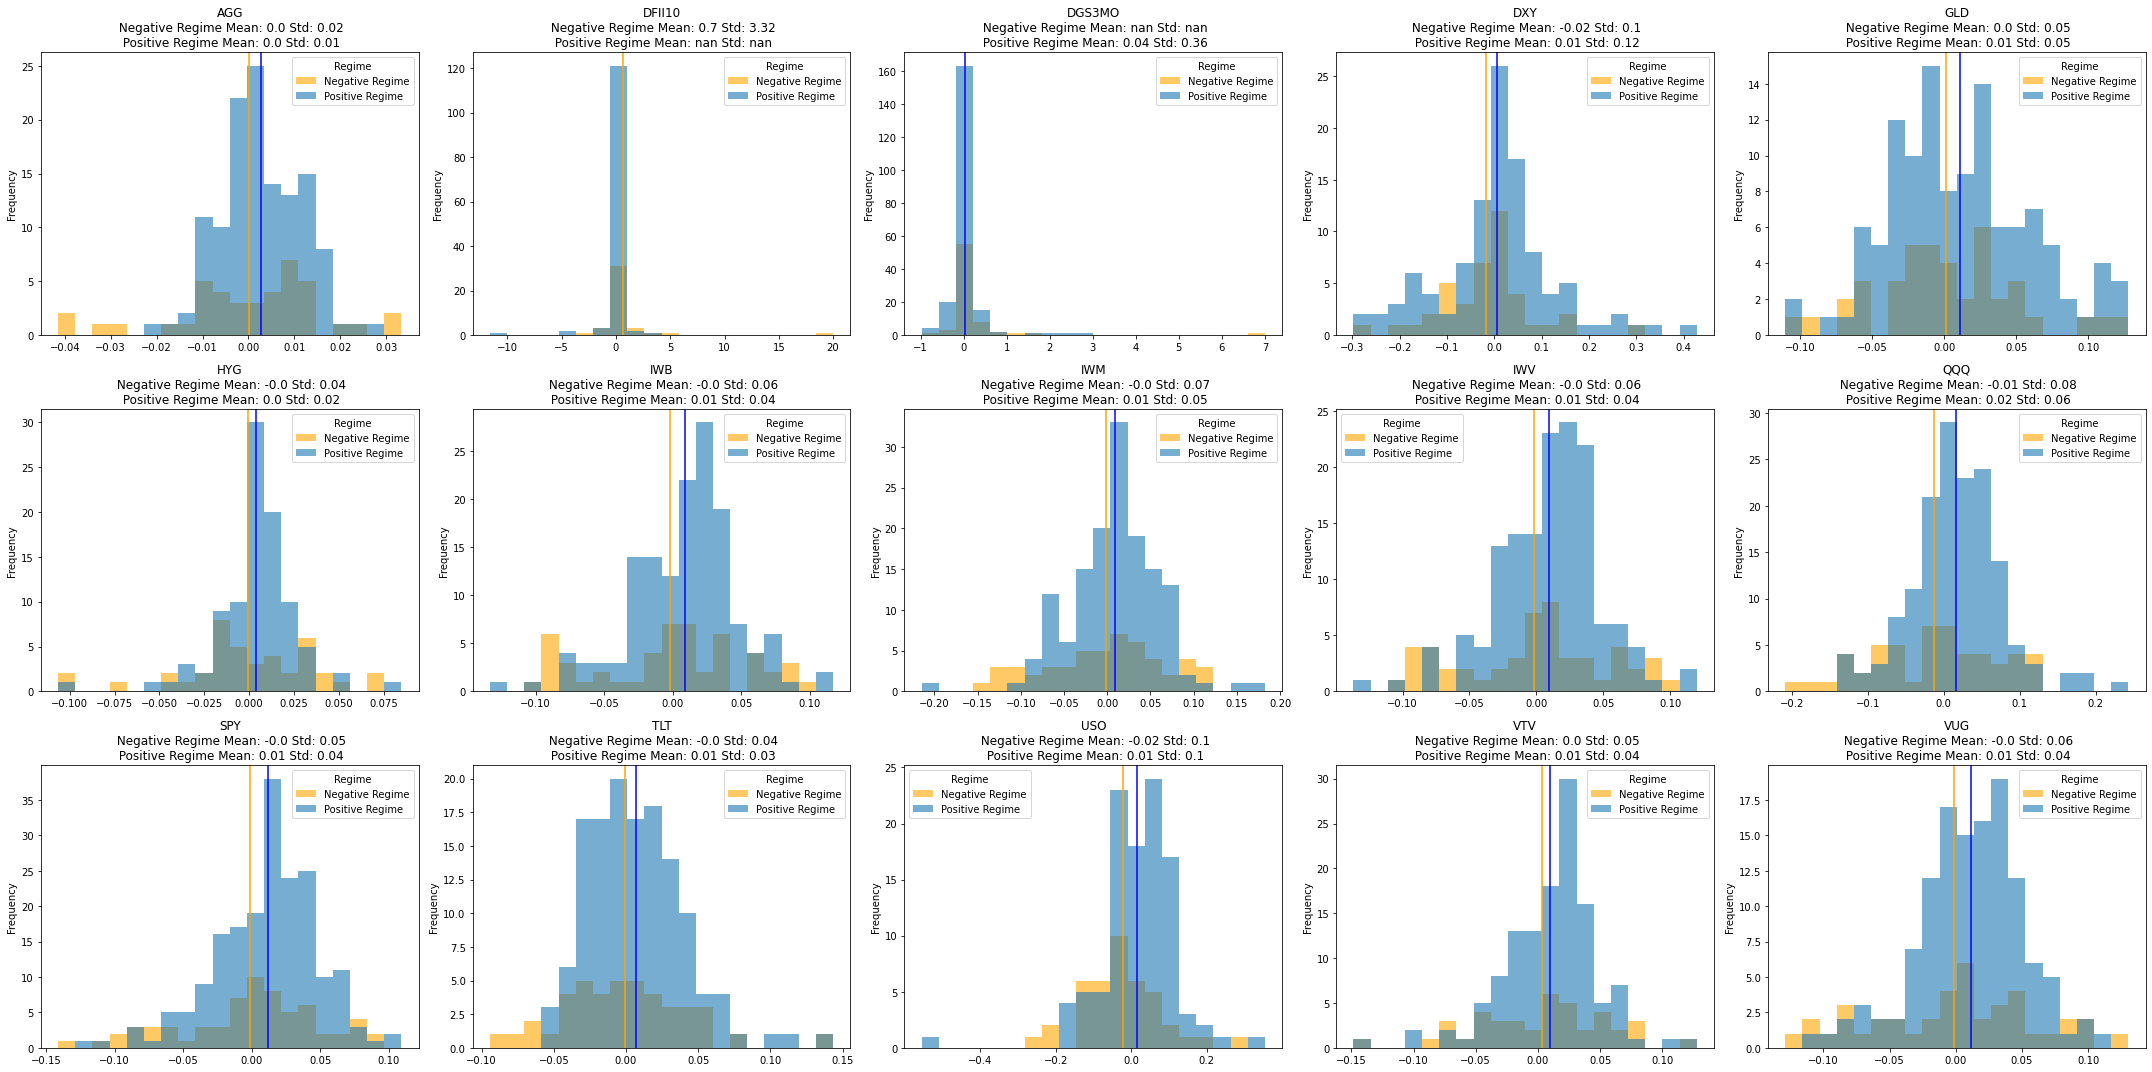

In [191]:
fig, axes = plt.subplots(ncols = 5, nrows = 3, figsize = (30,15))

j = 0
for i, group in enumerate(df_signal_combined.groupby(["ticker"])):

    ticker, df_tmp = group[0], group[1]
    
    df_tmp = (df_tmp.drop(
        columns = ["date", "ticker"]).
        assign(
            index = [i for i in range(len(df_tmp))],
            sign = lambda x: np.where(x.sign == -1, "Positive Regime", "Negative Regime")).
        rename(columns = {"sign": "Regime"}))
    
    df_stats = (df_tmp.drop(
        columns = ["index"]).
        groupby(["Regime"]).
        agg(["mean", "std"])
        ["value"].
        reset_index())
    
    neg_regime_mean, pos_regime_mean = df_stats.query("Regime == 'Negative Regime'")["mean"].iloc[0], df_stats.query("Regime == 'Positive Regime'")["mean"].iloc[0]
    neg_regime_std, pos_regime_std = df_stats.query("Regime == 'Negative Regime'")["std"].iloc[0], df_stats.query("Regime == 'Positive Regime'")["std"].iloc[0]
    
    (df_tmp.query(
        "value != -inf").
        query("value != inf").
        pivot(index = "index", columns = "Regime", values = "value").
        plot(
            kind = "hist",
            ax = axes[j,i%5],
            alpha = 0.6,
            bins = 20,
            xlabel = "(%)",
            color = ["orange", "tab:blue"],
            title = "{}\n Negative Regime Mean: {} Std: {}\n Positive Regime Mean: {} Std: {}".format(
                ticker,
                round(neg_regime_mean, 2),
                round(neg_regime_std, 2),
                round(pos_regime_mean, 2),
                round(pos_regime_std, 2))))
    
    axes[j, i%5].axvline(
        neg_regime_mean, 
        color = "orange")
    
    axes[j, i%5].axvline(
        pos_regime_mean, 
        color = "blue")
    
    if i % 5 == 4:
        j += 1
        
    if j == 3:
        break
   
plt.tight_layout()
plt.show()

# Comparing NYFed FCI vs. GS FCI

The fundamental problem that we have with this test, is that we cannot truly test which is more accurate. That is because the various financial conditions index is a generalization of financial conditions and thus what can we use to see if the FCI's have predictive power. For example various series to predict could be S&P 500 or real GDP, both are staggeringly different. Since the NYFed article references real GDP, we'll first test with that. We'll also test with S&P 500 since it measure financial conditions. 